### Importação dos dados



In [1]:
import pandas as pd
from pathlib import Path
import ipykernel
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"

loja = pd.read_csv(url)
loja2 = pd.read_csv(url2)
loja3 = pd.read_csv(url3)
loja4 = pd.read_csv(url4)

loja.head()

,Produto,Categoria do Produto,Preço,Frete,Data da Compra,Vendedor,Local da compra,Avaliação da compra,Tipo de pagamento,Quantidade de parcelas,lat,lon
0,Assistente virtual,eletronicos,219.08,9.249790,16/01/2021,Pedro Gomes,SP,4,cartao_credito,8,-22.19,-48.79
1,Mesa de jantar,moveis,256.35,11.234305,18/05/2022,Beatriz Moraes,RJ,1,cartao_credito,4,-22.25,-42.66
2,Jogo de tabuleiro,brinquedos,279.51,21.262681,15/03/2021,João Souza,DF,1,cartao_credito,1,-15.83,-47.86
3,Micro-ondas,eletrodomesticos,1009.99,54.667344,03/05/2022,João Souza,RS,4,boleto,1,-30.17,-53.50
4,Cadeira de escritório,moveis,446.99,26.964689,07/11/2020,Larissa Alves,MG,5,boleto,1,-18.10,-44.38


In [2]:
#Guardar as tabelas em uma lista

urls = [
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_1.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_2.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_3.csv",
    "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science/refs/heads/main/base-de-dados-challenge-1/loja_4.csv"
]

print('Total de Urls:', len(urls))


Total de Urls: 4


In [3]:
#Usar loop for para ler cada url e guardar em DataFrame dentro de uma lista

#lista vazia
tabelas = []

# para cada endereço u dentro da lista urls, repetimos o mesmo passo
for u in urls:
  df = pd.read_csv(u)
  tabelas.append(df)

# conferimos se coletamos 4 tabelas (uma por loja)
print("Total de DataFrames lidos:", len(tabelas))

# olhamos o formato da primeira tabela
print('Formato do 1 DF:', tabelas[0].shape)

# visualizar as 2 primeiras linhas da primeira tabela para ter certeza que deu tudo certo
tabelas[0].head(2)


Total de DataFrames lidos: 4
Formato do 1 DF: (2359, 12)


,Produto,Categoria do Produto,Preço,Frete,Data da Compra,Vendedor,Local da compra,Avaliação da compra,Tipo de pagamento,Quantidade de parcelas,lat,lon
0,Assistente virtual,eletronicos,219.08,9.249790,16/01/2021,Pedro Gomes,SP,4,cartao_credito,8,-22.19,-48.79
1,Mesa de jantar,moveis,256.35,11.234305,18/05/2022,Beatriz Moraes,RJ,1,cartao_credito,4,-22.25,-42.66


## Tratamento - Criação de lista com todas as lojas

In [4]:
# vamos criar uma nova lista para guardar as tabelas já com a coluna "Loja"
tabelas_loja = []


# enumerate(urls, start=1) nos dá pares (1, url1), (2, url2), ...
# "start=1" faz a contagem começar no 1 (fica assim: Loja 1, 2, 3, 4)
for i, u in enumerate(urls, start=1):
  df = pd.read_csv(u)            # lemos a URL u e obtemos a tabela df
  df["Loja"] = f"Loja {i}"    # criamos uma coluna chamada "Loja" informando de qual loja veio essa tabela
  tabelas_loja.append(df)     # adicionamos essa tabela (com a nova coluna) na lista tabelas_loja


# conferimos se a coluna "Loja" existe e o que ela contém no primeiro DataFrame
print("Exemplo de valores em 'Loja':", tabelas_loja[0]["Loja"].unique()[:3])


# olhamos 2 linhas do primeiro DataFrame para ver a coluna "Loja"
tabelas_loja[0].head(2)


Exemplo de valores em 'Loja': ['Loja 1']


,Produto,Categoria do Produto,Preço,Frete,Data da Compra,Vendedor,Local da compra,Avaliação da compra,Tipo de pagamento,Quantidade de parcelas,lat,lon,Loja
0,Assistente virtual,eletronicos,219.08,9.249790,16/01/2021,Pedro Gomes,SP,4,cartao_credito,8,-22.19,-48.79,Loja 1
1,Mesa de jantar,moveis,256.35,11.234305,18/05/2022,Beatriz Moraes,RJ,1,cartao_credito,4,-22.25,-42.66,Loja 1


## Tratamento - União das tabelas em uma única tabela.

In [5]:
# agora vamos empilhar (juntar) as 4 tabelas em uma só

dados = pd.concat(tabelas_loja, ignore_index=True) # ignore_index=True cria um novo índice sequencial (0,1,2,...) sem repetir

# conferimos o tamanho total da tabela final
print("Formato total:", dados.shape)

# verificamos quantas linhas pertencem a cada loja
print(dados["Loja"].value_counts())

#Verificar os valores distintos
print(dados["Loja"].unique())

# olhamos as 3 primeiras linhas para validar a estrutura final
dados.head(3)


Formato total: (9435, 13)
Loja
Loja 1    2359
Loja 2    2359
Loja 3    2359
Loja 4    2358
Name: count, dtype: int64
['Loja 1' 'Loja 2' 'Loja 3' 'Loja 4']


,Produto,Categoria do Produto,Preço,Frete,Data da Compra,Vendedor,Local da compra,Avaliação da compra,Tipo de pagamento,Quantidade de parcelas,lat,lon,Loja
0,Assistente virtual,eletronicos,219.08,9.249790,16/01/2021,Pedro Gomes,SP,4,cartao_credito,8,-22.19,-48.79,Loja 1
1,Mesa de jantar,moveis,256.35,11.234305,18/05/2022,Beatriz Moraes,RJ,1,cartao_credito,4,-22.25,-42.66,Loja 1
2,Jogo de tabuleiro,brinquedos,279.51,21.262681,15/03/2021,João Souza,DF,1,cartao_credito,1,-15.83,-47.86,Loja 1


In [6]:
# salvamos "dados" em um arquivo CSV no computador
# 1) Defina a pasta de destino (relativa ao notebook)
pasta = Path("data")                  # cria um caminho "data" (subpasta)

# 2) Garanta que a pasta exista
pasta.mkdir(exist_ok=True)            # cria a pasta se ela não existir

# 3) Monte o caminho completo do arquivo
arquivo = pasta / "dados_consolidados.csv"

# 4) Salve o DataFrame
dados.to_csv(arquivo, index=False)

# 5) Mostre o caminho absoluto para você saber exatamente onde ficou
print("CSV salvo em:", arquivo.resolve())


CSV salvo em: F:\Meu Drive\WM\Conhecimento\Cursos TI\Alura\ONE\Chalengers\Store\notebooks\data\dados_consolidados.csv


### Tratamento - Padronizar nomes de colunas (snake_case) 
- limpar espaços, 
- passar para minúsculo e 
- trocar espaço por "_".


In [7]:
# guardar nomes originais para comparar depois
colunas_originais = list(dados.columns)

# 2) Vamos criar uma nova lista vazia onde colocaremos os nomes padronizados
novos_nomes = []

# 3) Percorremos cada nome de coluna original
for c in dados.columns:
    # 3.1) limpamos espaços, passamos para minúsculo e trocamos espaço por "_"
    c_limpo = c.strip().lower().replace(" ", "_")
    # 3.2) adicionamos esse nome já padronizado na lista
    novos_nomes.append(c_limpo)

# 4) Atribuímos a lista pronta de volta ao DataFrame
dados.columns = novos_nomes

# 5) Conferimos o antes/depois
print("Antes :", colunas_originais)
print("Depois: ",list(dados.columns))


Antes : ['Produto', 'Categoria do Produto', 'Preço', 'Frete', 'Data da Compra', 'Vendedor', 'Local da compra', 'Avaliação da compra', 'Tipo de pagamento', 'Quantidade de parcelas', 'lat', 'lon', 'Loja']
Depois:  ['produto', 'categoria_do_produto', 'preço', 'frete', 'data_da_compra', 'vendedor', 'local_da_compra', 'avaliação_da_compra', 'tipo_de_pagamento', 'quantidade_de_parcelas', 'lat', 'lon', 'loja']


## Converter `data_da_compra` para datetime

In [8]:
# 0) Inspecionar o ESTADO ATUAL (antes da mudança)
print("Antes da mudança: ", dados["data_da_compra"].dtype)
 # Saida esperada: object (string)
dados["data_da_compra"] = pd.to_datetime(
        dados["data_da_compra"],
        dayfirst=True, errors="coerce"
    )
    #    1) Converter de STRING -> DATETIME
    #    dayfirst=True: interpreta '25/03/2024' como 25 de março (padrão BR)
    #    errors='coerce': datas inválidas viram NaT (nulo temporal), revelando sujeiras
# 3) Verificar o DEPOIS da mudança
print("dtype depois:", dados["data_da_compra"].dtype)      # esperado: datetime64[ns]


Antes da mudança:  object
dtype depois: datetime64[ns]


## Garantir numéricos em preço e frete

In [9]:
# converter para numérico (se existirem)
for col in dados[["preço", "frete"]]:
    if col in dados.columns:
        dados[col] = pd.to_numeric(dados[col], errors="coerce")


    # conferir
print("\nTipos depois:\n", dados[["preço","frete"]].dtypes)
print("\nAmostra depois:\n", dados[["preço","frete"]].head(3))



Tipos depois:
 preço    float64
frete    float64
dtype: object

Amostra depois:
     preço      frete
0  219.08   9.249790
1  256.35  11.234305
2  279.51  21.262681


## Diagnosticar e tratar nulos (NaN/NaT)

In [10]:
#Quantos vazios existem ANTES do tratamento?
print("Nulos antes:\n", dados.isna().sum())

#mesmo não existindo dados nulos irei fazer o for que substitui
#vazio por zero.
for col in ["preço", "frete"]:
    if col in dados.columns:
        dados[col] = dados[col].fillna(0)


#Quantos vazios existem DEPOIS do tratamento?
print("Nulos antes:\n", dados.isna().sum())


Nulos antes:
 produto                   0
categoria_do_produto      0
preço                     0
frete                     0
data_da_compra            0
vendedor                  0
local_da_compra           0
avaliação_da_compra       0
tipo_de_pagamento         0
quantidade_de_parcelas    0
lat                       0
lon                       0
loja                      0
dtype: int64
Nulos antes:
 produto                   0
categoria_do_produto      0
preço                     0
frete                     0
data_da_compra            0
vendedor                  0
local_da_compra           0
avaliação_da_compra       0
tipo_de_pagamento         0
quantidade_de_parcelas    0
lat                       0
lon                       0
loja                      0
dtype: int64


## 1. Análise do faturamento



### Faturamento total



In [11]:
#verificar se existe as colunas preço e frete
if ("preço" in dados.columns) and ("frete" in dados.columns):
    dados["receita"] = dados["preço"] + dados["frete"]
else:
    print("Atenção: faltam 'preço' e/ou 'frete'.")

print(dados[["preço", "frete", "receita"]].head(5))

#estatísticas descritivas
print("\nResumo receita:\n", dados["receita"].describe())

     preço      frete      receita
0   219.08   9.249790   228.329790
1   256.35  11.234305   267.584305
2   279.51  21.262681   300.772681
3  1009.99  54.667344  1064.657344
4   446.99  26.964689   473.954689

Resumo receita:
 count    9435.000000
mean      655.476572
std       828.976991
min        10.070000
25%        77.573282
50%       310.756900
75%       931.472497
max      4181.047060
Name: receita, dtype: float64


### Arredondar valores financeiros

In [12]:
# Arredonda as colunas para 2 casas decimais
dados['preço'] = dados['preço'].round(2)
dados['frete'] = dados['frete'].round(2)
dados['receita'] = dados['receita'].round(2)

print("Amostra com valores arredondados:")
print(dados[['preço', 'frete', 'receita']].head())

Amostra com valores arredondados:
     preço  frete  receita
0   219.08   9.25   228.33
1   256.35  11.23   267.58
2   279.51  21.26   300.77
3  1009.99  54.67  1064.66
4   446.99  26.96   473.95


### Derivar ano_mes (período mensal)

In [13]:
if "data_da_compra" in dados.columns:
    dados["ano_mes"] = dados["data_da_compra"].dt.to_period("M")
    print(dados[["data_da_compra", "ano_mes"]].head(5))
else:
    print("Atenção: 'data_da_compra' não é datetime")


  data_da_compra  ano_mes
0     2021-01-16  2021-01
1     2022-05-18  2022-05
2     2021-03-15  2021-03
3     2022-05-03  2022-05
4     2020-11-07  2020-11


### Faturamento mensal


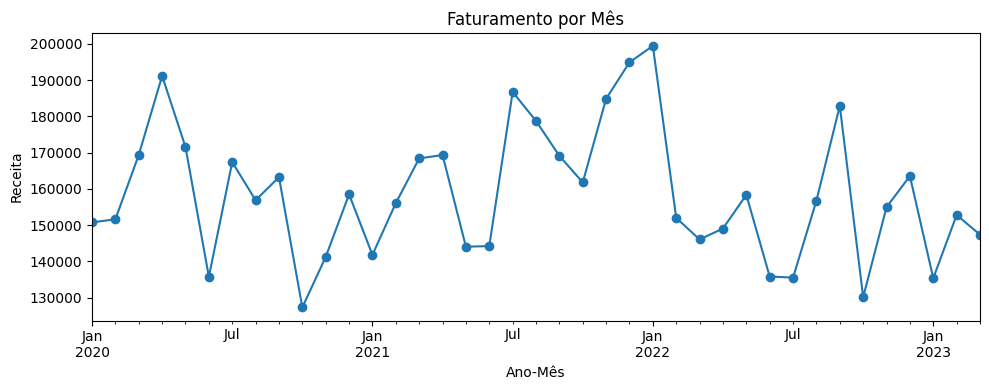

In [14]:

faturamento_mensal = (dados.groupby("ano_mes")["receita"].sum().sort_index())

plt.figure(figsize=(10,4))
faturamento_mensal.plot(marker='o')
plt.title("Faturamento por Mês")
plt.xlabel("Ano-Mês")
plt.ylabel("Receita")
plt.tight_layout()
plt.show()


### Faturamento por Categoria

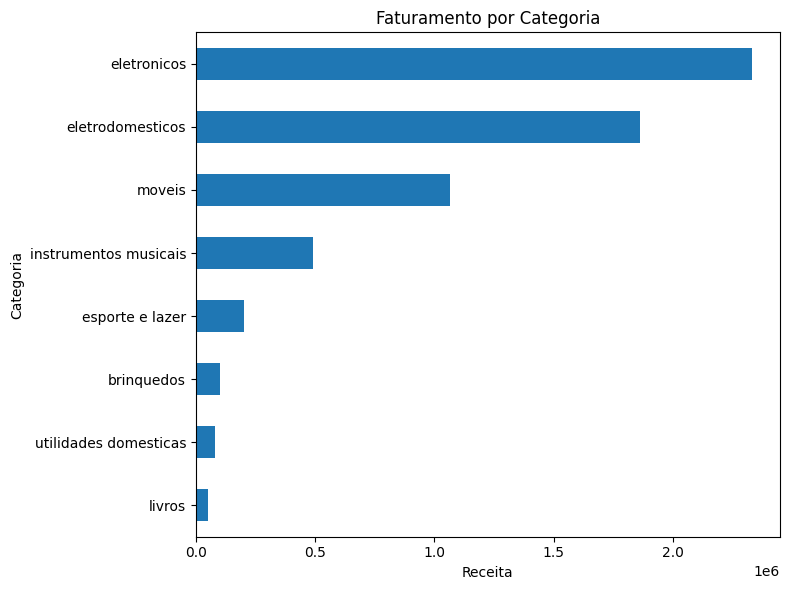

In [15]:
# 1. A AGREGAÇÃO (Calcular a receita por categoria)
faturamento_categoria = (dados.groupby("categoria_do_produto")["receita"].sum().sort_values(ascending=False))

# 2. A PREPARAÇÃO E DESENHO
plt.figure(figsize=(8,6))

#3. O DESENHO (Plotar o gráfico de barras)
faturamento_categoria.sort_values(ascending=True).plot(kind="barh")
plt.title("Faturamento por Categoria")
plt.xlabel("Receita")
plt.ylabel("Categoria")
plt.tight_layout()
plt.show()


# 2. Vendas por Categoria

categoria_do_produto
moveis                   1886
eletronicos              1772
brinquedos               1290
eletrodomesticos         1149
esporte e lazer          1113
instrumentos musicais     753
livros                    742
utilidades domesticas     730
Name: count, dtype: int64


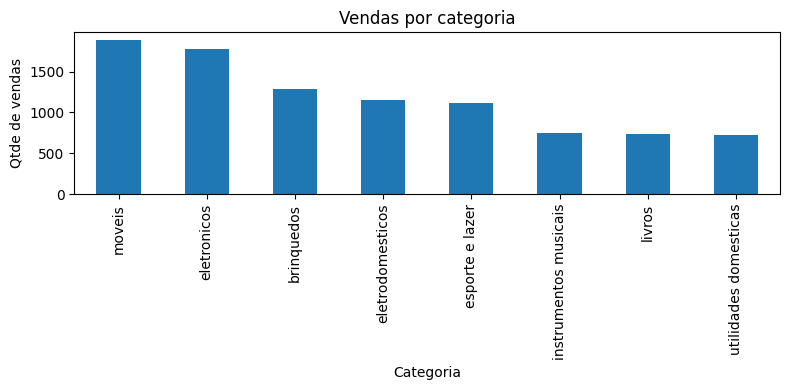

In [16]:
#Conte quantas vezes cada valor único aparece nesta Series
vendas_categoria = dados["categoria_do_produto"].value_counts()
print(vendas_categoria)

#A PREPARAÇÃO (Criar a "tela" do gráfico)
plt.figure(figsize=(8,4))

#O DESENHO (Plotar o gráfico de barras)
vendas_categoria.plot(kind="bar")
#O CONTEXTO (Adicionar Título e Rótulos)
plt.title("Vendas por categoria")
plt.xlabel("Categoria")
plt.ylabel("Qtde de vendas")


#A FINALIZAÇÃO (Ajustar e Mostrar)
plt.tight_layout()
plt.show()


# 3. Média de Avaliação das Lojas


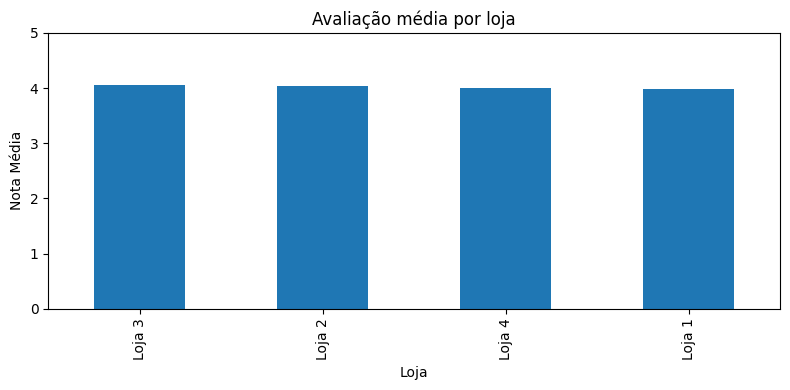

In [17]:
#A AGREGAÇÃO (Calcular a nota média e ordenar)
avaliacao_media = dados.groupby("loja")["avaliação_da_compra"].mean().sort_values(ascending=False)

#A PREPARAÇÃO (Criar a "tela" do gráfico)
plt.figure(figsize=(8,4))
#O DESENHO (Plotar o gráfico de barras)
avaliacao_media.plot(kind="bar")
#O CONTEXTO (Adicionar Título e Rótulos)
plt.title("Avaliação média por loja")
plt.xlabel("Loja")
plt.ylabel("Nota Média")
#O AJUSTE DE EIXO (Definir limite da nota)
plt.ylim(0,5)
#A FINALIZAÇÃO (Ajustar e Mostrar)
plt.tight_layout()
plt.show()


# 4. Produtos Mais e Menos Vendidos

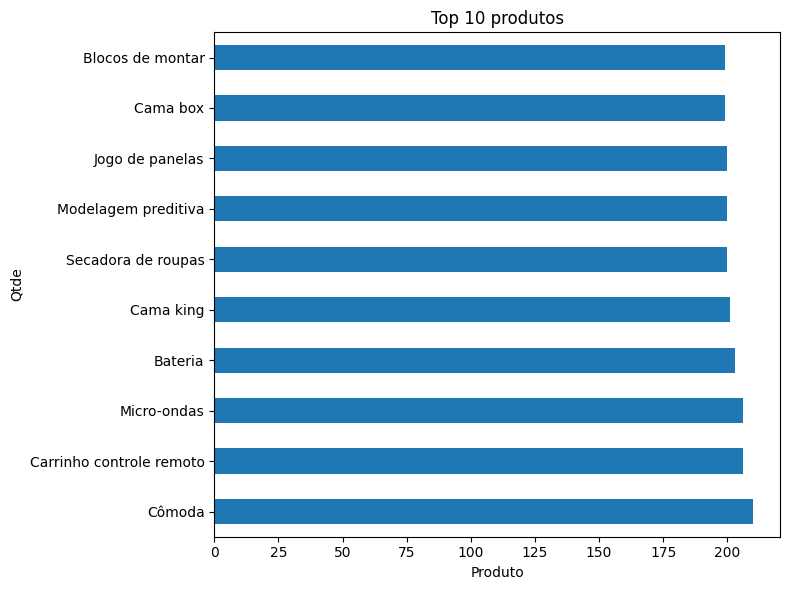

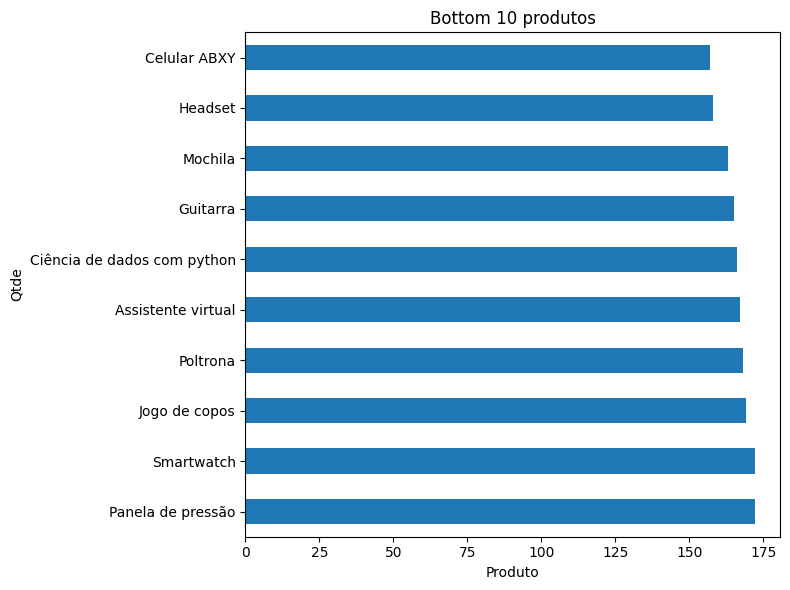

In [18]:
#A CONTAGEM GERAL (Contar todos os produtos)
vendas_produto = dados["produto"].value_counts()
#print(vendas_produto)

#O FILTRO "TOP 10" (Pegar os 10 melhores)
top_n = vendas_produto.head(10)
#print(top_n)

#O FILTRO "BOTTOM 10" (Pegar os 10 piores)
bottom_n = vendas_produto.tail(10)
#print(bottom_n)

#GRÁFICO 1 (Visualizar os "Top 10")
plt.figure(figsize=(8,6))
top_n.plot(kind="barh")
plt.title("Top 10 produtos")
plt.xlabel("Produto")
plt.ylabel("Qtde")
plt.tight_layout()
plt.show()

#GRÁFICO 2 (Visualizar os "Bottom 10")
plt.figure(figsize=(8,6))
bottom_n.plot(kind="barh")
plt.title("Bottom 10 produtos")
plt.xlabel("Produto")
plt.ylabel("Qtde")
plt.tight_layout()
plt.show()


# 5. Frete Médio por Loja

loja
Loja 4    31.279042
Loja 3    33.074392
Loja 2    33.621971
Loja 1    34.691763
Name: frete, dtype: float64


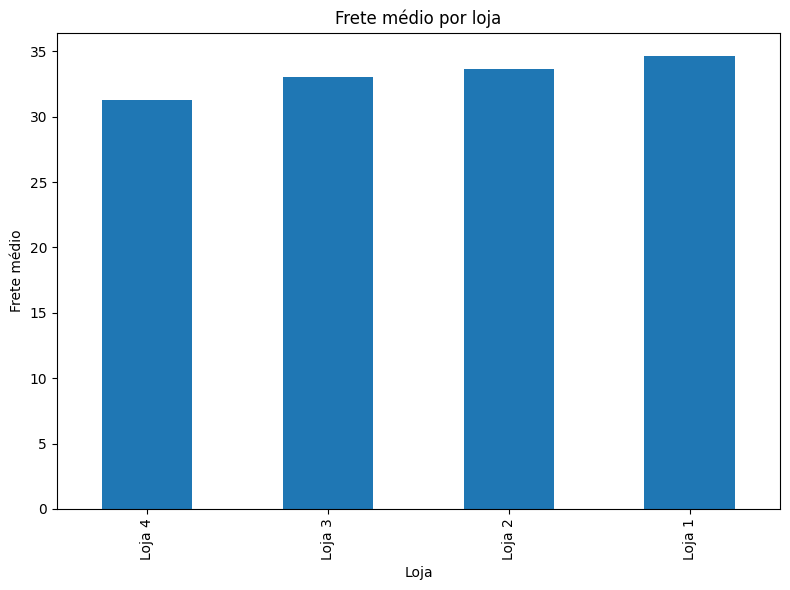

In [19]:
#A AGREGAÇÃO (Calcular o frete médio e ordenar)
frete_medio = (dados.groupby("loja")["frete"].mean().sort_values())
print(frete_medio)

#A PREPARAÇÃO (Criar a "tela" do gráfico)
plt.figure(figsize=(8,6))

#O DESENHO (Plotar o gráfico de barras)
frete_medio.plot(kind="bar")

#O CONTEXTO (Adicionar Título e Rótulos)
plt.title("Frete médio por loja")
plt.xlabel("Loja"); plt.ylabel("Frete médio")

#A FINALIZAÇÃO (Ajustar e Mostrar)
plt.tight_layout(); plt.show()
